In [91]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from scipy.optimize import curve_fit

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.png'

In [92]:
Gfile = '../data/kepler_dr2_1arcsec.fits' # from http://gaia-kepler.fun, thanks to M. Bedell
data = Table.read(Gfile, format='fits')

df = data.to_pandas()
df.shape

(195830, 101)

In [93]:
ok = np.where(np.isfinite(df[u'parallax']) & # this is basically the same as the TGAS file...
              (df[u'parallax_error'] < 0.1) &
              (df[u'r_modality_flag'] == 1) & 
              (df[u'r_result_flag'] == 1) &
              np.isfinite(df[u'bp_rp']) & 
              (df[u'phot_bp_mean_flux_error']/df[u'phot_bp_mean_flux'] < 0.01) & 
              (df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01) & 
              (df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01))[0]

ok.shape

(180993,)

In [94]:
koi_raw = pd.read_csv('../data/q1_q17_dr25_koi.csv', comment='#')

koi = pd.merge(df, koi_raw, right_on='kepid', left_on='kepid')
koi.shape

(7935, 241)

In [95]:
koiok = np.where(np.isfinite(koi[u'parallax']) & # this is basically the same as the TGAS file...
                (koi[u'parallax_error'] < 0.1) &
                (koi[u'r_modality_flag'] == 1) & 
                (koi[u'r_result_flag'] == 1) &
                np.isfinite(koi[u'bp_rp']) & 
                (koi[u'phot_bp_mean_flux_error']/koi[u'phot_bp_mean_flux'] < 0.01) & 
                (koi[u'phot_rp_mean_flux_error']/koi[u'phot_rp_mean_flux'] < 0.01) & 
                (koi[u'phot_g_mean_flux_error']/koi[u'phot_g_mean_flux'] < 0.01))[0]
koiok.shape

(7199,)

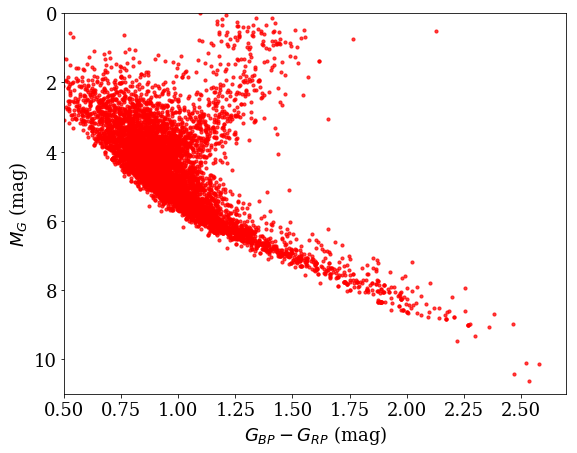

In [96]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral_r')

# plt.scatter(df[u'bp_rp'].values[ok], 
#             df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
#             alpha=0.5, s=1, c='k', label='Kepler Objects')

Mg_abs = koi[u'phot_g_mean_mag'].values[koiok] - 5. * np.log10(koi[u'r_est'].values[koiok])  + 5

plt.scatter(koi[u'bp_rp'].values[koiok], Mg_abs,
            alpha=0.75, s=10, c='r', label='KOIs')

# plt.legend(fontsize=12)

plt.ylim(11,0)
plt.xlim(.5,2.7)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

plt.savefig('../figures/KOIonly_cmd'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

In [97]:
#  MIST isochrones
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = '../iso/mist/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
#MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

mist_ms1 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] == 9.) & 
                    (mist['Gaia_G_DR2Rev'] > 2))[0][::-1]


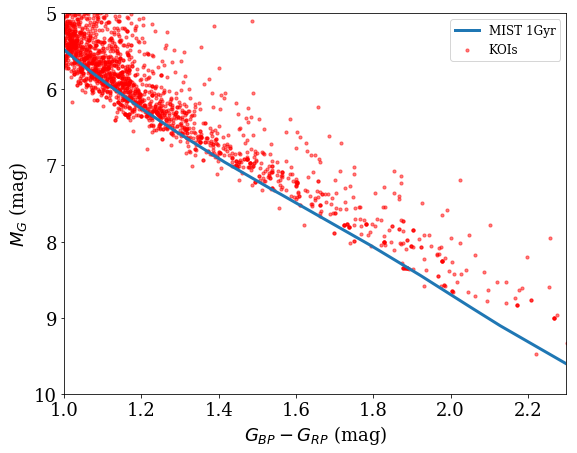

In [98]:
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral_r')

# plt.scatter(df[u'bp_rp'].values[ok], 
#             df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
#             alpha=0.15, s=5, c='k', label='Kepler Objects')

plt.scatter(koi[u'bp_rp'].values[koiok], Mg_abs, 
            alpha=0.5, s=10, c='r', label='KOIs')

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], lw=3, label='MIST 1Gyr')

plt.legend(fontsize=12)

plt.ylim(10,5)
plt.xlim(1,2.3)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.savefig('../figures/KOI_zoom_cmd'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

In [99]:
# MIST isochrone
Mg_iso_mist = np.interp(koi[u'bp_rp'].values[koiok], mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
                        mist['Gaia_G_DR2Rev'].values[mist_ms1])

delta_mag = Mg_iso_mist - Mg_abs
delta_mag.shape

(7199,)

(1, 220)


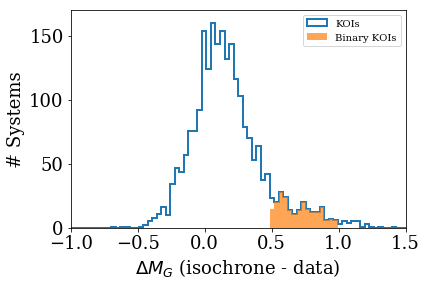

In [103]:
# lets pick out binary exoplanet candidates from this window

msok = np.where((Mg_abs >= 5) & (Mg_abs < 8))

_ = plt.hist(delta_mag[msok], histtype='step', bins=np.linspace(-1,1.5,75), label='KOIs', lw=2)
plt.xlim(-1,1.5)
plt.ylim(0,170)
# plt.plot([0.5, 0.5], [0,170], c='orange')
# plt.plot([1,1], [0,170], c='orange')

BinStars = np.where((delta_mag[msok] > 0.5) & (delta_mag[msok] < 1))
print(np.shape(BinStars))

_ = plt.hist(delta_mag[msok][BinStars], bins=np.linspace(-1,1.5,75), alpha=0.7, label='Binary KOIs')

plt.legend(fontsize=10)

plt.xlabel(r'$\Delta M_G$ (isochrone - data)')
plt.ylabel('# Systems')
plt.savefig('../figures/KOI_binaries'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

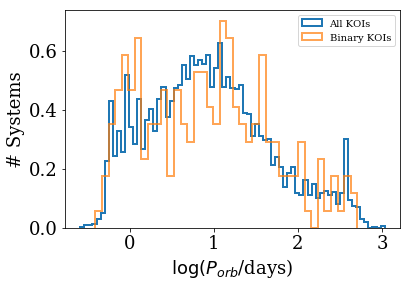

In [102]:
_=plt.hist(np.log10(koi['koi_period'][koiok]), histtype='step',bins=75, normed=True, lw=2, label='All KOIs')

_=plt.hist(np.log10(koi['koi_period'][koiok[msok][BinStars]]), histtype='step',bins=40, normed=True, 
           lw=2, label='Binary KOIs', alpha=0.7)

plt.legend(fontsize=10)

plt.xlabel(r'$\log(P_{orb}$/days)')
plt.ylabel('# Systems')
plt.savefig('../figures/KOI_Porb'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

#---> No apparent difference in the orbital periods of binary planets... that seems interesting to me!